# Definição do Tema
É um conjunto de dados que reflete operações de comércio eletrônico no Brasil, hospedado na plataforma Kaggle. Contém diversas tabelas inter-relacionadas (como pedidos, produtos, clientes, pagamentos, revisões e geolocalização) que possui informações de 100 mil pedidos de 2016 a 2018 feitos em vários locais no Brasil, onde seus recursos permitem visualizar um pedido em várias dimensões.

# Objetivo
Foi solicitado pela empresa uma segmentação de perfil de clientes com base na quantidade de compras feitas, o objetivo é direcionar o time de marketing e vendas para atrair clientes e não perder os que não compram há um tempo considerável (sendo considerável o período a ser julgado pelo Cientista de Dados).

# Preparação dos Dados
Pré-processamento de dados executados:
- Preenchimento de valores ausentes com a mediana;
- Normalização com StandardScaler;
- Criação de features auxiliares;
- Redução de Dimensionalidade de dados com Principal Component Analysis;

# Importação de bibliotecas e bases de dados

In [1]:
import pandas as pd
import numpy as np
from numpy import unique, where
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Exibição de gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Visualiza dados faltantes (NaN), assim como o pandas
import missingno

# Scaler
from sklearn.preprocessing import StandardScaler
# Aplica o algoritmo Kmeans, DBSCAN e OPTICS
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.neighbors import NearestNeighbors
# Métrica para escolha de número de clusters
from sklearn.metrics import silhouette_score
# PCA
from sklearn.decomposition import PCA

In [51]:
# importando as bases de dados
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')

### Analisando tipos, quantidades e tamanho das bases

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [6]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [7]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [52]:
# Agrupando as bases em uma só
df1 = pd.merge(customers, orders, on='customer_id')
df2 = pd.merge(df1, reviews, on='order_id')
df3 = pd.merge(df2, payments, on='order_id')
df = pd.merge(df3, order_items, on='order_id')

df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1,credit_card,2,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,1,credit_card,8,335.48,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,1,credit_card,7,157.73,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,1,credit_card,1,173.30,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,1,credit_card,8,252.25,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [9]:
print(f"A base possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

A base possui 117329 linhas e 28 colunas.


In [10]:
# Exibindo a base agrupada
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    117329 non-null  object 
 1   customer_unique_id             117329 non-null  object 
 2   customer_zip_code_prefix       117329 non-null  int64  
 3   customer_city                  117329 non-null  object 
 4   customer_state                 117329 non-null  object 
 5   order_id                       117329 non-null  object 
 6   order_status                   117329 non-null  object 
 7   order_purchase_timestamp       117329 non-null  object 
 8   order_approved_at              117314 non-null  object 
 9   order_delivered_carrier_date   116094 non-null  object 
 10  order_delivered_customer_date  114858 non-null  object 
 11  order_estimated_delivery_date  117329 non-null  object 
 12  review_id                     

### Criando variáveis auxiliares

In [4]:
# Agrupando e totalizando quantas compras um mesmo cliente fez
total_compras_por_cliente = df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
total_compras_por_cliente.columns = ['customer_unique_id', 'total_compras']
total_compras_por_cliente['total_compras'].value_counts()

total_compras
1     91851
2      2635
3       186
4        29
5         9
6         5
7         3
9         1
16        1
Name: count, dtype: int64

Como esperado, a maioria dos clientes comprou uma vez, enquanto, a minoria comprou mais de uma vez.

In [53]:
# mesclando essa informação ao dataset original
df = pd.merge(df, total_compras_por_cliente, on='customer_unique_id')

In [13]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_compras
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1,credit_card,2,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,1,credit_card,8,335.48,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,1,credit_card,7,157.73,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,1,credit_card,1,173.30,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,1,credit_card,8,252.25,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1


In [54]:
# criando o tempo médio de entrega e adicionando ao dataframe original
df['tempo_medio_entrega'] = (pd.to_datetime(df['order_delivered_customer_date']) - pd.to_datetime(df['order_purchase_timestamp'])).dt.days

df['tempo_medio_entrega'] = df.groupby('customer_unique_id')['tempo_medio_entrega'].transform('mean')

In [15]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_compras,tempo_medio_entrega
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1,credit_card,2,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,8.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,1,credit_card,8,335.48,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1,16.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,1,credit_card,7,157.73,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1,26.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,1,credit_card,1,173.30,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1,14.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,1,credit_card,8,252.25,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1,11.0


In [55]:
# Criando o valor médio do frete para cada cliente
df['avg_freight_value'] = df.groupby('customer_unique_id')['freight_value'].transform('mean')

In [17]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_compras,tempo_medio_entrega,avg_freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1,credit_card,2,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,8.0,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,1,credit_card,8,335.48,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1,16.0,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,1,credit_card,7,157.73,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1,26.0,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,1,credit_card,1,173.30,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1,14.0,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,1,credit_card,8,252.25,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1,11.0,22.25


In [56]:
# Criando e adicionando a coluna que contabiliza quantidade de dias que o cliente não compra, tomando como base o período que o dataset abrange: 2016 a 2018.
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

df['days_since_last_purchase'] = (df['order_purchase_timestamp'].max() - df.groupby('customer_unique_id')['order_purchase_timestamp'].transform('max')).dt.days

In [19]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1,credit_card,2,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,8.0,21.88,474
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,1,credit_card,8,335.48,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1,16.0,46.48,233
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,1,credit_card,7,157.73,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1,26.0,17.79,106
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,1,credit_card,1,173.30,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1,14.0,23.36,173
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,1,credit_card,8,252.25,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1,11.0,22.25,35


In [57]:
# Total gasto por cada cliente
total_gasto = df.groupby('customer_unique_id')['payment_value'].sum().reset_index()

total_gasto.columns = ['customer_unique_id', 'total_gasto']
# acrescenta ao dataframe original
df = pd.merge(df, total_gasto, on='customer_unique_id')

In [21]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1,credit_card,2,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,8.0,21.88,474,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,1,credit_card,8,335.48,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1,16.0,46.48,233,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,1,credit_card,7,157.73,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1,26.0,17.79,106,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,1,credit_card,1,173.30,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1,14.0,23.36,173,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,1,credit_card,8,252.25,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1,11.0,22.25,35,252.25


In [58]:
# Review médio por cada cliente
media_review_score = df.groupby('customer_unique_id')['review_score'].mean().reset_index()

media_review_score.columns = ['customer_unique_id', 'media_review_score']
# mesclando ao dataset
df = pd.merge(df, media_review_score, on='customer_unique_id')

In [23]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1,credit_card,2,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,8.0,21.88,474,146.87,4.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,1,credit_card,8,335.48,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1,16.0,46.48,233,335.48,5.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,1,credit_card,7,157.73,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1,26.0,17.79,106,157.73,5.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,1,credit_card,1,173.30,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1,14.0,23.36,173,173.30,5.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,1,credit_card,8,252.25,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1,11.0,22.25,35,252.25,5.0


In [59]:
# Média de parcelas feitas no ato da compra
parcelas_medias = df.groupby('customer_unique_id')['payment_installments'].mean().reset_index()

parcelas_medias.columns = ['customer_unique_id', 'media_parcelas']

df = pd.merge(df, parcelas_medias, on='customer_unique_id')

In [25]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score,media_parcelas
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1,credit_card,2,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,8.0,21.88,474,146.87,4.0,2.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,1,credit_card,8,335.48,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1,16.0,46.48,233,335.48,5.0,8.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,1,credit_card,7,157.73,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1,26.0,17.79,106,157.73,5.0,7.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,1,credit_card,1,173.30,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1,14.0,23.36,173,173.30,5.0,1.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,1,credit_card,8,252.25,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1,11.0,22.25,35,252.25,5.0,8.0


# Análise Exploratória de Dados (EDA)

In [60]:
# Removendo colunas dispensáveis ao estudo de caso que é o perfil de clientes
colunas_para_remover = [
    'customer_id', 'order_id', 'customer_zip_code_prefix', 'order_status',
    'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
    'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_id',
    'review_score', 'review_comment_title', 'review_comment_message',
    'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
    'payment_type', 'payment_installments', 'payment_value', 'order_item_id',
    'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value',
    'customer_city', 'customer_state'
]

df.drop(columns=colunas_para_remover, inplace=True)

In [27]:
df.head()

,customer_unique_id,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score,media_parcelas
0,861eff4711a542e4b93843c6dd7febb0,1,8.0,21.88,474,146.87,4.0,2.0
1,290c77bc529b7ac935b93aa66c333dc3,1,16.0,46.48,233,335.48,5.0,8.0
2,060e732b5b29e8181a18229c7b0b2b5e,1,26.0,17.79,106,157.73,5.0,7.0
3,259dac757896d24d7702b9acbbff3f3c,1,14.0,23.36,173,173.30,5.0,1.0
4,345ecd01c38d18a9036ed96c73b8d066,1,11.0,22.25,35,252.25,5.0,8.0


In [28]:
# Estatísticas descritivas do dataset
df.describe()

,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score,media_parcelas
count,117329.000000,115004.000000,117329.000000,117329.000000,117329.000000,117329.000000,117329.000000
mean,1.088512,11.980265,20.027514,243.210869,376.458888,4.031467,2.940151
std,0.399972,9.299777,15.498882,153.146176,1574.501647,1.374028,2.735093
min,1.000000,0.000000,0.000000,0.000000,9.590000,1.000000,0.000000
25%,1.000000,6.000000,13.230000,119.000000,70.540000,3.685714,1.000000
50%,1.000000,10.000000,16.320000,223.000000,134.900000,5.000000,2.000000
75%,1.000000,15.000000,21.140000,352.000000,282.400000,5.000000,4.000000
max,16.000000,208.000000,409.680000,728.000000,109312.640000,5.000000,24.000000


In [29]:
# Verificando existência e tratando valores nulos
valores_nulos = df.isnull().sum()
valores_nulos_df = pd.DataFrame({'Coluna':valores_nulos.index, 'Quantidade de Valores Nulos':valores_nulos.values})

In [30]:
valores_nulos_df

,Coluna,Quantidade de Valores Nulos
0,customer_unique_id,0
1,total_compras,0
2,tempo_medio_entrega,2325
3,avg_freight_value,0
4,days_since_last_purchase,0
5,total_gasto,0
6,media_review_score,0
7,media_parcelas,0


<Axes: >

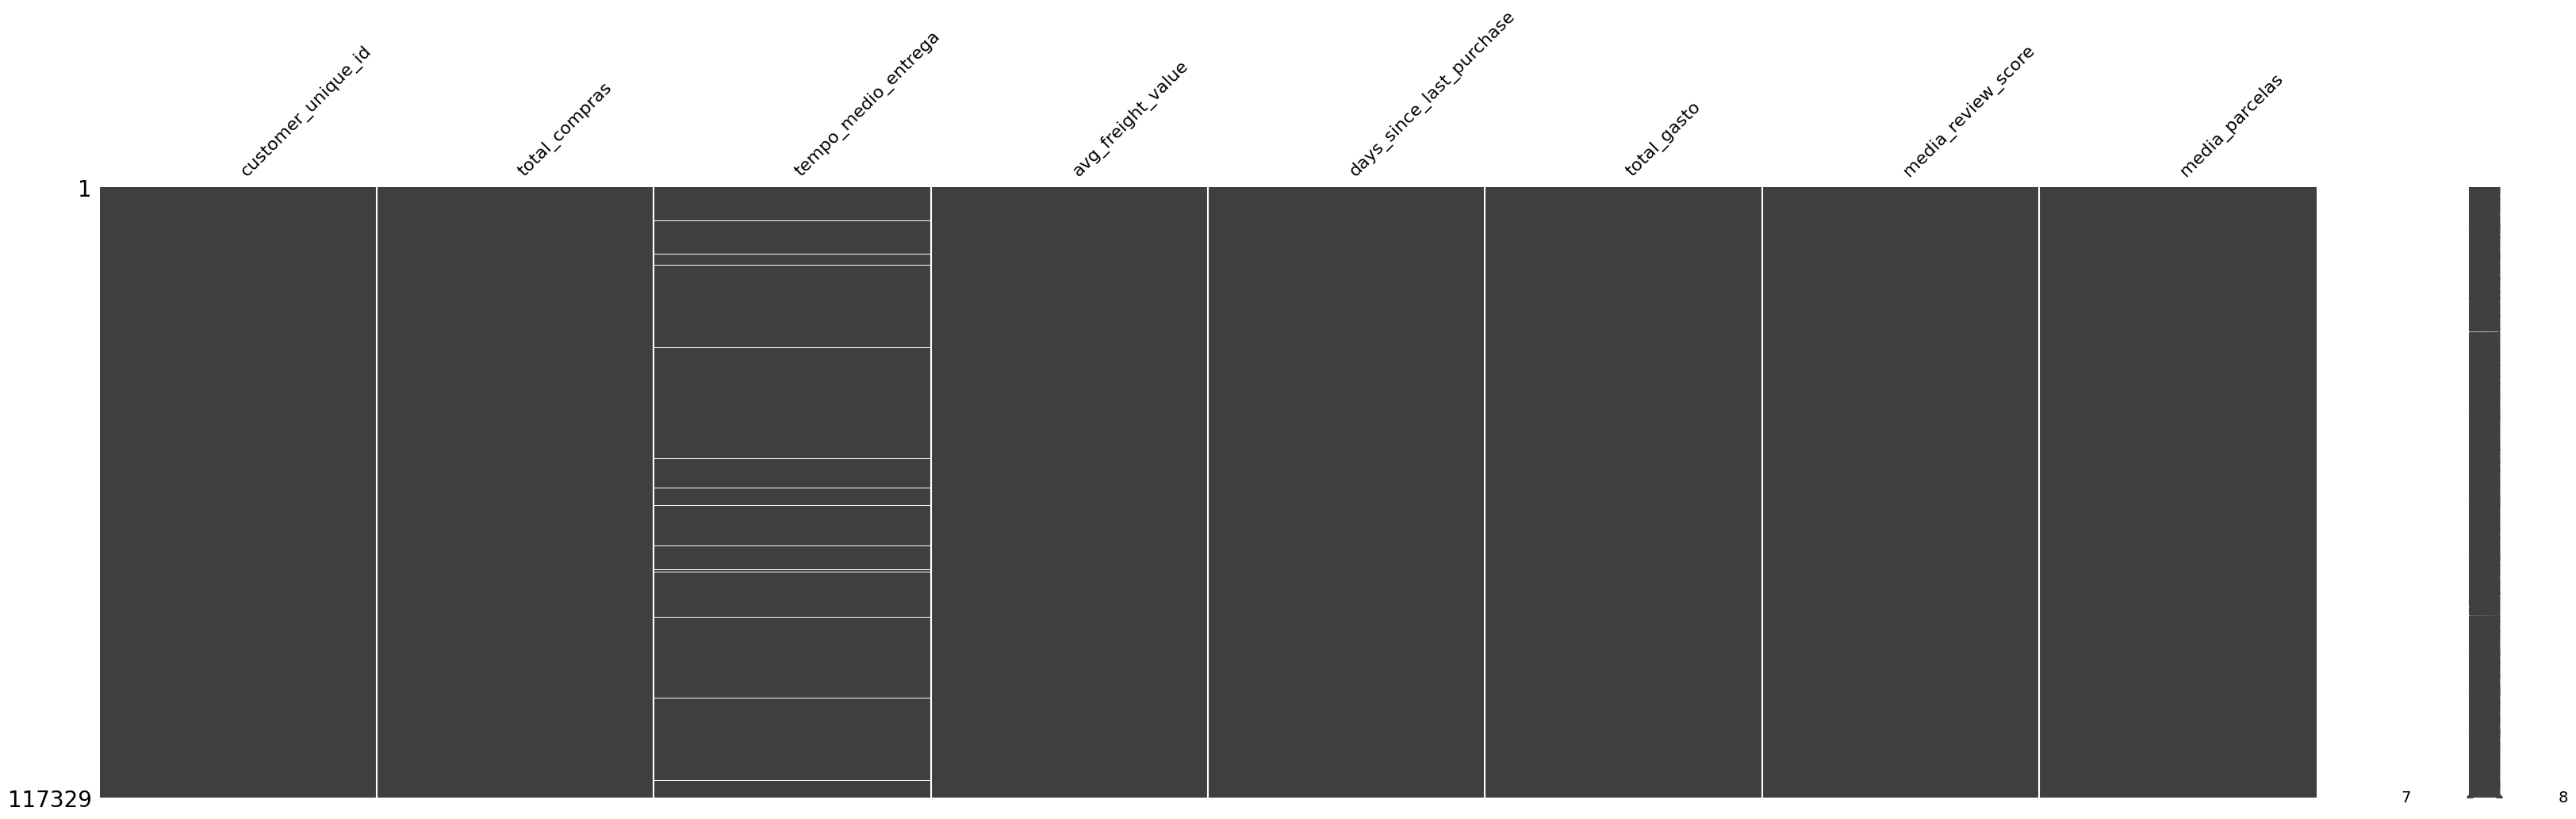

In [31]:
# exibindo as colunas que possuem valores ausentes, linhas horizontais = valores nulos
missingno.matrix(df, figsize=(40,10))

In [61]:
df['tempo_medio_entrega'].fillna(df['tempo_medio_entrega'].median(), inplace=True)

In [33]:
# Verificando se foi aplicado o preenchimento dos valores nulos pela mediana
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_unique_id        117329 non-null  object 
 1   total_compras             117329 non-null  int64  
 2   tempo_medio_entrega       117329 non-null  float64
 3   avg_freight_value         117329 non-null  float64
 4   days_since_last_purchase  117329 non-null  int64  
 5   total_gasto               117329 non-null  float64
 6   media_review_score        117329 non-null  float64
 7   media_parcelas            117329 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 7.2+ MB


In [34]:
# Verificando duplicatas
df[df.duplicated()]

,customer_unique_id,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score,media_parcelas
21,a96d5cfa0d3181817e2b946f921ea021,1,10.000000,17.670,322,698.13,1.0,2.0
22,a96d5cfa0d3181817e2b946f921ea021,1,10.000000,17.670,322,698.13,1.0,2.0
35,e079b18794454de9d2be5c12b4392294,2,13.666667,16.655,445,1482.62,5.0,8.0
37,ef07ba9aa5226f77264ffa5762b2280b,1,10.000000,15.230,174,45.73,5.0,1.0
49,d251c190ca75786e9ab937982d60d1d4,1,8.000000,13.470,137,101.84,2.0,1.0
...,...,...,...,...,...,...,...,...
117302,b96d6a178adbabf269fd843b37327798,1,14.000000,14.100,222,176.00,5.0,4.5
117311,4452b8ef472646c4cc042cb31a291f3b,1,9.000000,12.480,282,32.38,4.0,1.0
117312,4452b8ef472646c4cc042cb31a291f3b,1,9.000000,12.480,282,32.38,4.0,1.0
117316,82d46759af0369aad49084bacf85a6c3,1,35.000000,31.930,292,199.92,1.0,3.0


In [62]:
# removendo duplicatas
df = df.drop_duplicates()

In [36]:
# Verificando a remoção das duplicatas
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94720 entries, 0 to 117328
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        94720 non-null  object 
 1   total_compras             94720 non-null  int64  
 2   tempo_medio_entrega       94720 non-null  float64
 3   avg_freight_value         94720 non-null  float64
 4   days_since_last_purchase  94720 non-null  int64  
 5   total_gasto               94720 non-null  float64
 6   media_review_score        94720 non-null  float64
 7   media_parcelas            94720 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 6.5+ MB


### Correlação de Pearson
Mapa de calor exibindo correlação positiva/negativa entre as variáveis

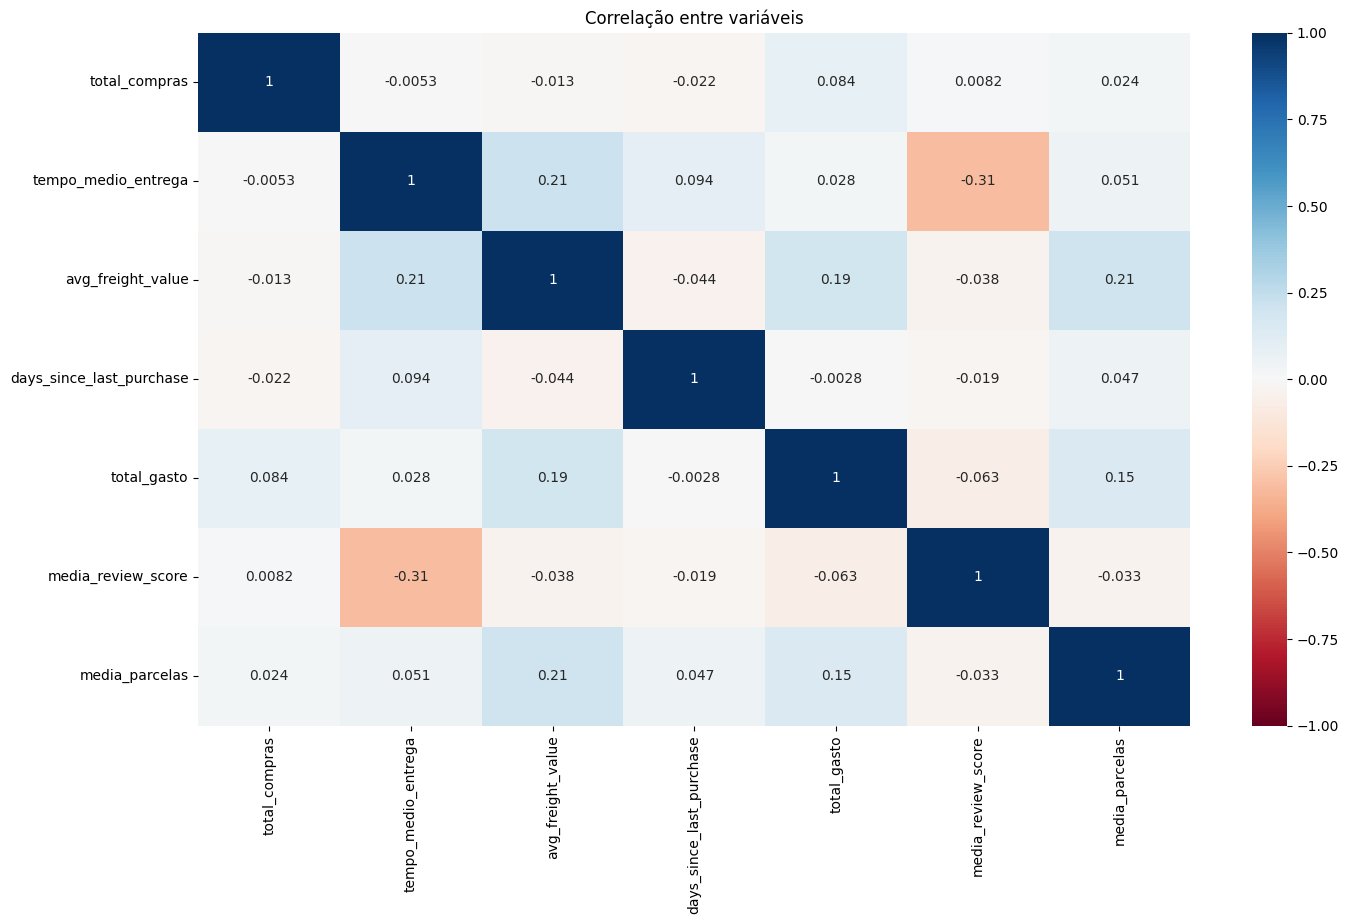

In [37]:
# Exibindo o mapa de calor com todas as variáveis contínuas
plt.figure(figsize=(16,9))
sns.heatmap(df.iloc[:, 1:].corr(), annot=True, vmin=-1, vmax=1, cmap='RdBu')
plt.title("Correlação entre variáveis")
plt.show()

A correlação de Pearson demonstra que há uma correlação positiva fraca entre as variáveis:
- `media_parcelas` e `avg_freight_value`;
- `total_gasto` e `avg_freight_value`; e
- `total_gasto` e `media_parcelas`.

# Normalizando o dataset
Algoritmos de agrupamento necessitam de normalização em razão da distância entre os pontos de dados serem altamente relevantes.

In [15]:
# Aplicando Scaler no dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.iloc[:, 1:])

# Resultados e Predição
Algoritmos Não Supervisionados utilizados:
- KMeans:
    - Apliquei as métricas de análise de cluster: Índice de Silhouette e o método do "cotovelo" visualizando o comportamento do Erro Quadrático (inércia) dependendo do número de clusters;
    - Optei por 4 clusters com base nas duas métricas supracitadas;
    - Utilizei RFM para identificar a segmentação de clientes que o KMeans distribuiu com base nas features originais.
    - Resultados obtidos através do KMeans com PCA em duas dimensões se saiu ligeiramente melhor nas duas métricas.
- DBSCAN (com PCA):
    - Maior Índice de Silhouette (0.54), identificou 4 clusters e uma visualização coesa dos mesmos.
    - Não utilizando o PCA, DSBSCAN gerou 158 clusters e os resultados também não foram interpretáveis. Este último, removido do código.
- OPTICS:
    - Sem PCA: Identificou mais de mil clusters, maioria das instâncias identificadas como outliers;
    - Com PCA: Identificou aproximadamente 2 mil clusters, maioria das instâncias também foram classificadas como outliers;
    - Não interpretável em razão do número de clusters.

### Cluster com K-Means

Decidindo o Número de Clusters

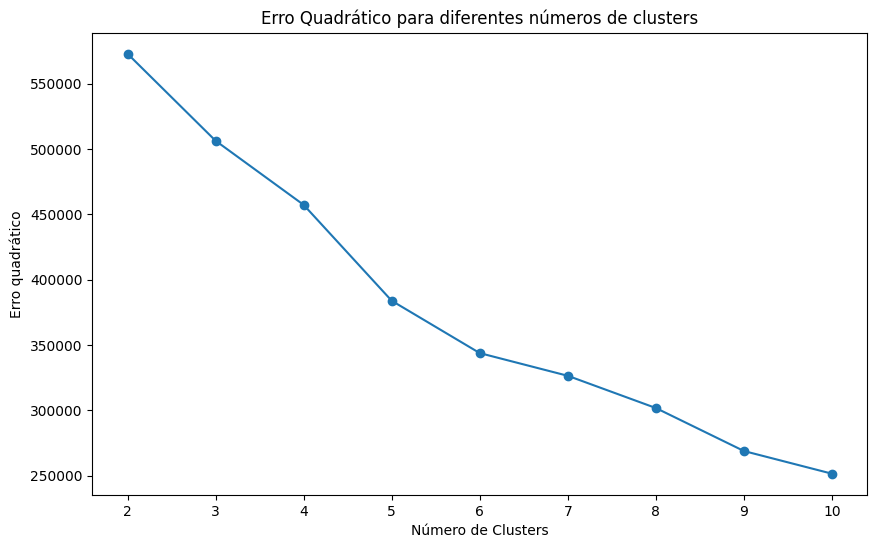

In [39]:
# Métrica que calcula (a inércia) o Erro quadrático de cada cluster, quanto menor, mais denso o cluster
erro_quadratico = list()
for i in range(2,11):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(scaled_features)
    erro_quadratico.append(km.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(2,11), erro_quadratico, marker='o')
plt.title("Erro Quadrático para diferentes números de clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Erro quadrático")
plt.show()

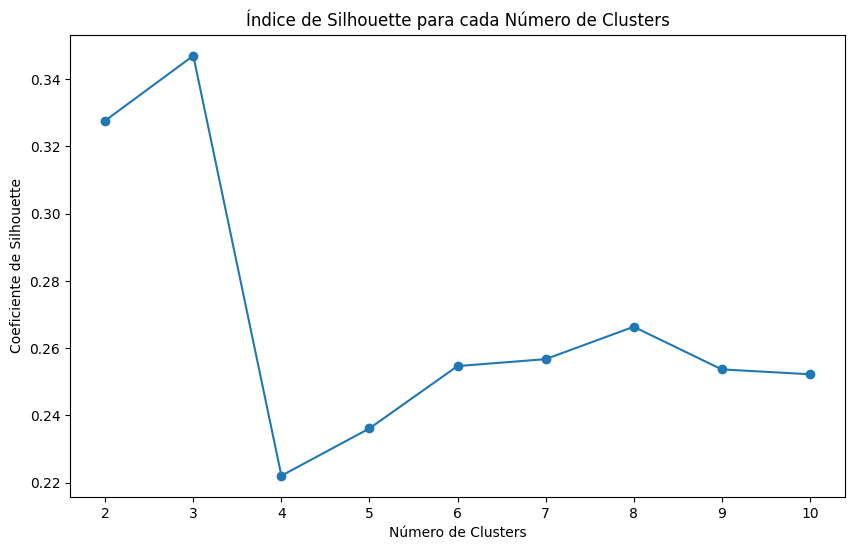

In [ ]:
# Índice de Silhouette, identificando se o objeto está bem alocado no cluster.
silhouette = list()
for i in range(2,11):
    kmeans = KMeans(n_clusters=i, init='random')
    kmeans.fit(scaled_features)
    silhouettescore = silhouette_score(scaled_features, kmeans.labels_)
    silhouette.append(silhouettescore)
    
plt.figure(figsize=(10,6))
plt.plot(range(2,11), silhouette, marker='o')
plt.title("Índice de Silhouette para cada Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Coeficiente de Silhouette")
plt.show()

Aproximadamente 450 mil de inércia e 0.22 do Índice de Silhouette para 4 clusters. Como quero quatro perfis de clientes, opto por 4 clusters. O correto seria o maior índice de Silhouette e a menor inércia (erro quadrático).

In [ ]:
# Após analisar o Erro Quadrático e o Índice de Silhouette, decido por utilizar 4 clusters
kmeans = KMeans(n_clusters=4, n_init=10, init='k-means++', max_iter=300)
kmeans.fit(scaled_features)

KMeans(n_clusters=4, n_init=10)

In [42]:
df_Kmeans = df.copy()
df_Kmeans.drop(columns='customer_unique_id', axis=1, inplace=True)
df_Kmeans['cluster'] = kmeans.labels_

df_Kmeans

,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score,media_parcelas,cluster
0,1,8.0,21.88,474,146.87,4.0,2.0,1
1,1,16.0,46.48,233,335.48,5.0,8.0,3
2,1,26.0,17.79,106,157.73,5.0,7.0,3
3,1,14.0,23.36,173,173.30,5.0,1.0,1
4,1,11.0,22.25,35,252.25,5.0,8.0,3
...,...,...,...,...,...,...,...,...
117324,1,6.0,13.88,148,88.78,4.0,6.0,1
117325,1,7.0,14.16,152,129.06,5.0,3.0,1
117326,1,30.0,19.04,147,56.04,1.0,5.0,0
117327,1,12.0,22.07,303,711.07,5.0,2.0,1


In [43]:
# media de variáveis por cluster
df_Kmeans.groupby('cluster').mean()

,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score,media_parcelas
cluster,,,,,,,
0,1.000000,20.672874,20.476647,250.548882,213.264453,1.628975,2.562936
1,1.000000,9.801996,16.893576,238.865996,135.703050,4.645098,1.840828
2,2.113977,11.798685,18.986982,225.544441,486.175936,4.146823,3.305139
3,1.000000,12.364109,33.884699,252.099266,478.981247,4.378853,7.528872


In [44]:
# mediana de variáveis por cluster
df_Kmeans.groupby('cluster').median()

,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score,media_parcelas
cluster,,,,,,,
0,1.0,17.000000,17.150,223.0,118.86,1.000000,2.000000
1,1.0,9.000000,15.370,221.0,90.72,5.000000,1.000000
2,2.0,10.333333,16.440,204.0,261.45,4.666667,2.333333
3,1.0,11.000000,22.595,237.0,231.27,5.000000,8.000000


In [45]:
# terceiro quantil do boxplot de variáveis por cluster
df_Kmeans.groupby('cluster').quantile(0.75)

,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score,media_parcelas
cluster,,,,,,,
0,1.0,28.000000,22.3500,328.0,218.060,2.0,4.0
1,1.0,13.000000,18.7900,351.0,153.130,5.0,2.0
2,2.0,14.666667,20.7100,325.0,468.460,5.0,5.0
3,1.0,16.000000,39.7075,377.0,455.655,5.0,10.0


### Análise Univariada

### Análise da variável - Tempo Médio de Entrega

Text(0, 0.5, 'Tempo Médio de Entrega em Dias')

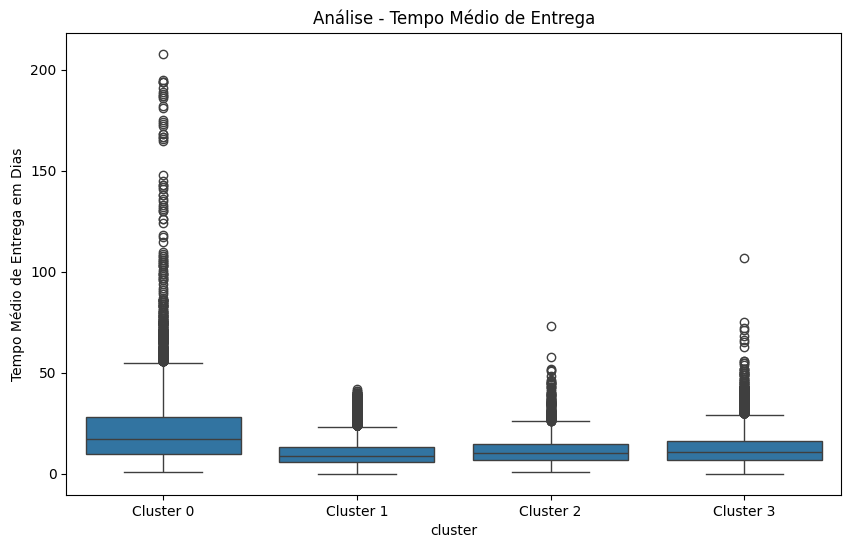

In [46]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_Kmeans, x='cluster', y='tempo_medio_entrega')
plt.xticks(range(4), ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title("Análise - Tempo Médio de Entrega")
plt.ylabel("Tempo Médio de Entrega em Dias")

- Cluster 0 possui o maior tempo médio de entrega e seus outliers representam tempos ainda maiores dentre os clusters. É provável que os clientes deste cluster não estejam satisfeitos com o serviço.
- Cluster 1 possui o menor tempo médio de entrega.

### Análise da Variável - Dias desde a última compra

Text(0, 0.5, 'Quantidade de dias sem comprar')

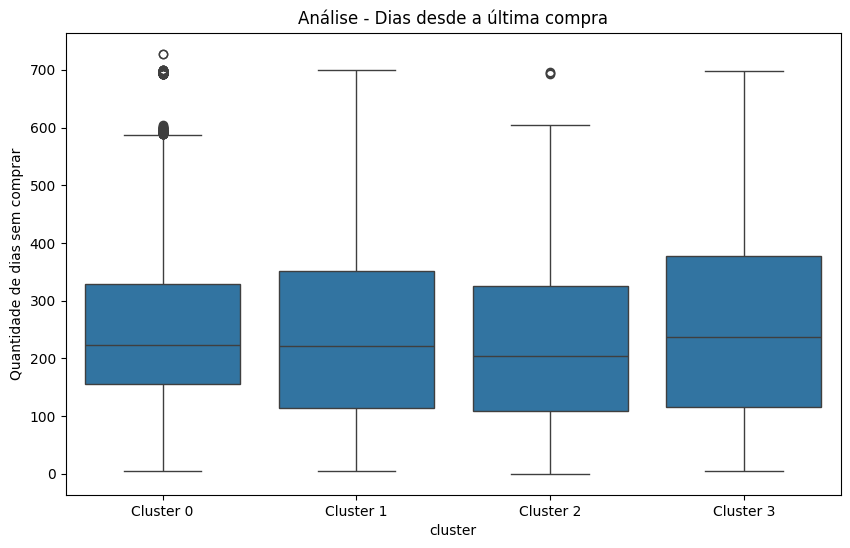

In [47]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_Kmeans, x='cluster', y='days_since_last_purchase')
plt.xticks(range(4), ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title("Análise - Dias desde a última compra")
plt.ylabel("Quantidade de dias sem comprar")

Medianas parecidas em quantidade de dias desde a última compra, em torno de 230 dias para cada cluster, sendo o com a maior mediana o cluster 3.

### Análise da Variável - Total Gasto

Text(0, 0.5, 'Total Gasto (em reais)')

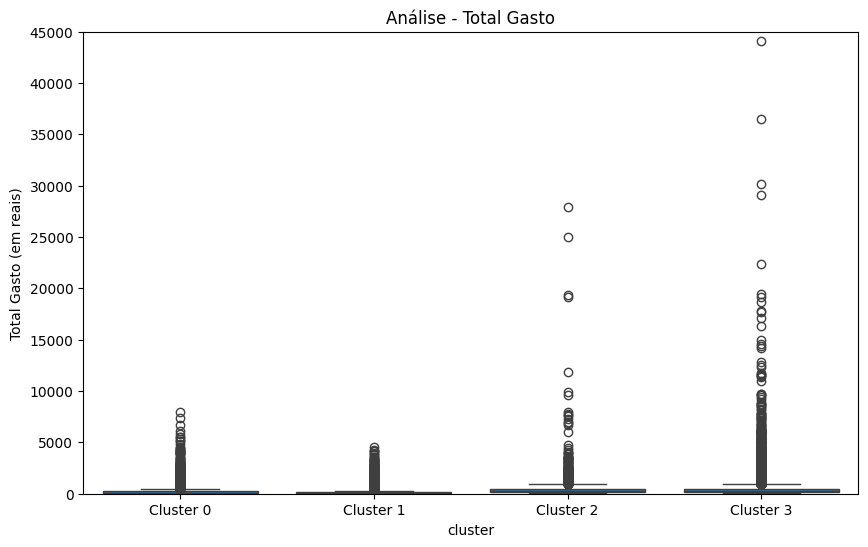

In [48]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_Kmeans, x='cluster', y='total_gasto')
plt.ylim(0, 45000) # limite de 45 mil unidades no eixo Y devido à um outlier acima de 100 mil no cluster 2
plt.xticks(range(4), ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title("Análise - Total Gasto")
plt.ylabel("Total Gasto (em reais)")

Este boxplot ficou de difícil visualização, ao invés de limitar o eixo Y para 5.000 (exemplo do gráfico acima) e fazer uma análise individual por coluna, decidi pesquisar outra forma de visualizar a distribuição dos dados para cada coluna. É possível fazer esta análise de uma forma melhor e sucinta com o gráfico de radar.

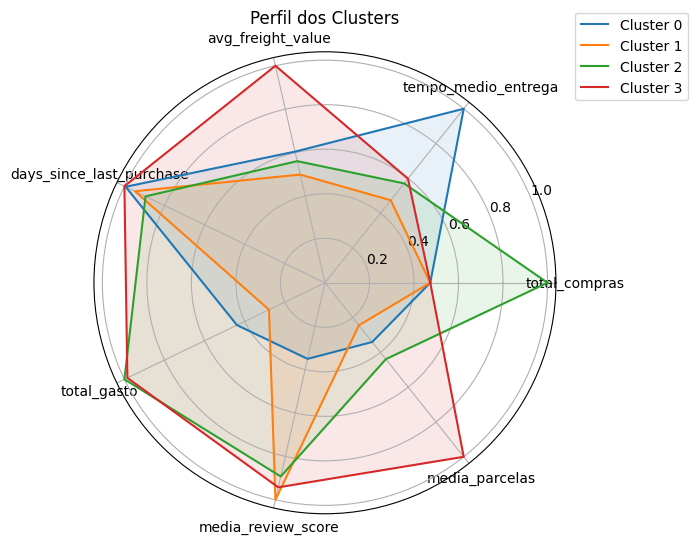

In [49]:
# Agrupando e Normalizando para a mesma escala, médias por cluster
cluster_avg = df_Kmeans.groupby('cluster').mean(numeric_only=True)
cluster_avg = cluster_avg.div(cluster_avg.max())  # normalização

# defino as labels sendo nome das colunas
labels = cluster_avg.columns
n_vars = len(labels)

# definindo o design como gráfico de
angles = np.linspace(0, 2 * np.pi, n_vars, endpoint=False).tolist()
angles += angles[:1]  # fecha o gráfico

# define o gráfico como subplots e itera sob as colunas e ângulos, adicionando-os
fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

for i, row in cluster_avg.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Perfil dos Clusters")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

## RFM x Análise dos clusters
RFM é uma métrica de marketing utilizada para identificar perfil de clientes e posteriormente executar propagandas, ofertas exclusivas e interações direcionadas.
Utiliza-se da escala de 0 a 5 ou 0 a 10 nos seguintes critérios:
- Recência: Tempo desde a última compra;
- Frequência: Quantidade de compras feitas desde que se cadastrou; e
- Monetariedade: Maior/Total valor gasto.

A base de dados foi normalizada para escala de 0 a 1, logo, usarei um RFM de 0 a 10 (0,1 a 1) com base nos clusters.

#### Cluster 0
É um grupo de novos clientes ou clientes de baixo valor.
- Frequência baixa
- Valor monetário baixo
- Parcelamento baixo
- Review alto e recência boa (acabaram de comprar)

#### Cluster 1
É um cluster de clientes promissores.
- Review score alto
- Valor monetário bom e frete alto
- Parcelamento alto
- Recência boa
- Frequência baixa (total_compras baixo)

#### Cluster 2
Melhores clientes (Campeões do RFM)
- Recência baixa (a parte ruim é que faz muito tempo desde que compraram pela última vez)
- Frequência alta
- Alto valor monetário

#### Cluster 3
Parcela de clientes em risco ou insatisfeitos
- Recência muito ruim (maior tempo desde a última compra)
- Valor monetário baixo
- Review score muito baixo
- Frequência baixa
- Tempo médio de entrega mais alto

Observação: Caso eu utilizasse o RFM antes da aplicação dos modelos não-supervisionados como colunas da base de dados, iria reforçar um viés de segmentação de clientes usando a monetização, frequência e recência, sendo que estes três já existem como features (total_gasto, total_compras e days_since_last_purchase). Prefiro avaliar estes grupos com as features que criei até o momento e analisar os clusters resultantes (não-supervisionado) com a perspectiva do RFM. Não há uma convenção sobre a ordem de execução.

### Análise Multivariada

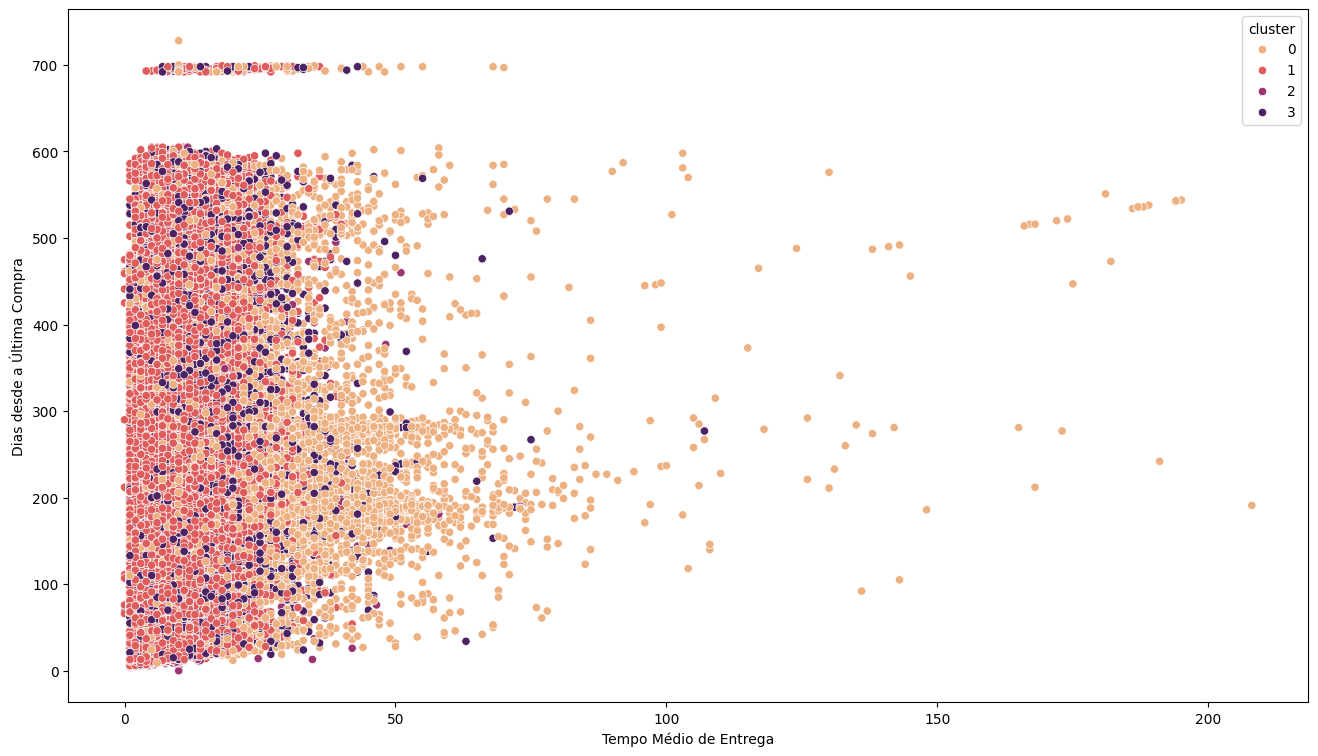

In [50]:
# Gráfico de pontos, comparando tempo médio de entrega com dias desde a última compra

plt.figure(figsize=(16,9))
sns.scatterplot(data=df_Kmeans, x='tempo_medio_entrega', y='days_since_last_purchase', hue='cluster', palette='flare')
plt.xlabel('Tempo Médio de Entrega')
plt.ylabel('Dias desde a Última Compra')
plt.show()

Como vimos antes para os clusters 0 e 1:
- Cluster 0 tem o maior tempo de entrega.
- Cluster 1 possui em média o menor tempo de entrega.
- Clusters 2 e 3 estão mais complicados de identificar algum padrão neste gráfico. Optarei por exibir mais uma dimensão, desta vez, utilizando a feature `media_parcelas`.

# Aplicando Principal Component Analysis (PCA)

In [53]:
pca = PCA()
pca.fit(scaled_features)

PCA()

In [54]:
variancia = pca.explained_variance_ratio_
df_variancia = pd.DataFrame(variancia, index=[f'PC{i+1}' for i in range(len(variancia))], columns=["Variancia_Explicada"])
variancia_cumulativa = pca.explained_variance_ratio_.cumsum()

df_variancia['Variancia_Cumulativa'] = variancia_cumulativa

df_variancia

,Variancia_Explicada,Variancia_Cumulativa
PC1,0.219081,0.219081
PC2,0.171546,0.390627
PC3,0.145396,0.536023
PC4,0.143310,0.679333
PC5,0.120578,0.799911
PC6,0.115362,0.915273
PC7,0.084727,1.000000


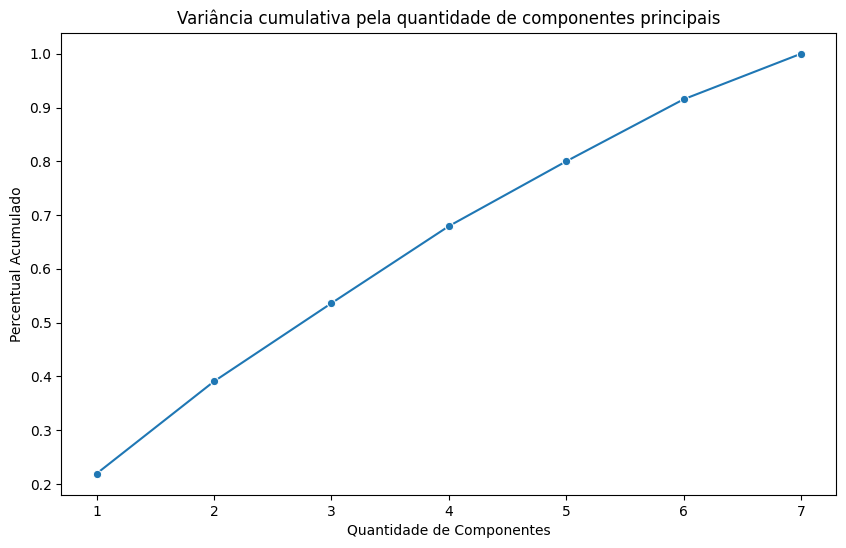

In [ ]:
# exibe a variância cumulativa por quantidade de componentes principais da tabela acima
plt.figure(figsize=(10,6))
sns.lineplot(x=range(1,8), y=df_variancia['Variancia_Cumulativa'], markers = True, marker='o')
plt.title("Variância cumulativa pela quantidade de componentes principais")
plt.xlabel("Quantidade de Componentes")
plt.ylabel("Percentual Acumulado")
plt.show()

Testarei os algoritmos de agrupamento para 80% de variância (5 dimensões) e para 39% de variância (2 componentes principais), mantendo 39% da essência do dataset visando interpretar os resultados nos gráficos e analisar o comportamento da inércia (que tende a diminuir) e do coeficiente de Silhouette.

In [ ]:
# para cinco componentes principais
pca = PCA(n_components=5)
pca.fit(scaled_features)

PCA(n_components=5)

In [ ]:
# exibindo os pesos de cada feature do dataset original
pca.components_

array([[ 0.04887889,  0.51526721,  0.51264385,  0.09344082,  0.3735737 ,
        -0.40876813,  0.39233526],
       [ 0.27100359, -0.4565045 ,  0.26955238, -0.26522475,  0.43400236,
         0.49385563,  0.37802991],
       [ 0.66661667,  0.09931892, -0.14288751, -0.5372124 ,  0.11631819,
        -0.32232855, -0.34542488],
       [ 0.57606226, -0.02865406, -0.31050532,  0.73657458,  0.13016704,
         0.02936417,  0.10280972],
       [-0.36923976, -0.22955485, -0.2769818 ,  0.08064082,  0.7582877 ,
        -0.25429676, -0.29677874]])

In [58]:
df_comp = pd.DataFrame(data=pca.components_,
    columns=['total_compras', 'tempo_medio_entrega', 'avg_freight_value', 'days_since_last_purchase', 'total_gasto', 'media_review_score', 'media_parcelas'],
    index = ['Componente 1', 'Componente 2', 'Componente 3', 'Componente 4', 'Componente 5'])

df_comp

,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score,media_parcelas
Componente 1,0.048879,0.515267,0.512644,0.093441,0.373574,-0.408768,0.392335
Componente 2,0.271004,-0.456504,0.269552,-0.265225,0.434002,0.493856,0.378030
Componente 3,0.666617,0.099319,-0.142888,-0.537212,0.116318,-0.322329,-0.345425
Componente 4,0.576062,-0.028654,-0.310505,0.736575,0.130167,0.029364,0.102810
Componente 5,-0.369240,-0.229555,-0.276982,0.080641,0.758288,-0.254297,-0.296779


Podemos ver qual componente possui mais informações de determinada feature original analisando os valores por coluna e componente principal.

Por exemplo: O componente 1 (PC1) possui 4% de informação de total_compras, enquanto o PC3 possui 66% da variância original da mesma feature.

### Mapa de Calor
Entre as variáveis originais e os 5 componentes principais

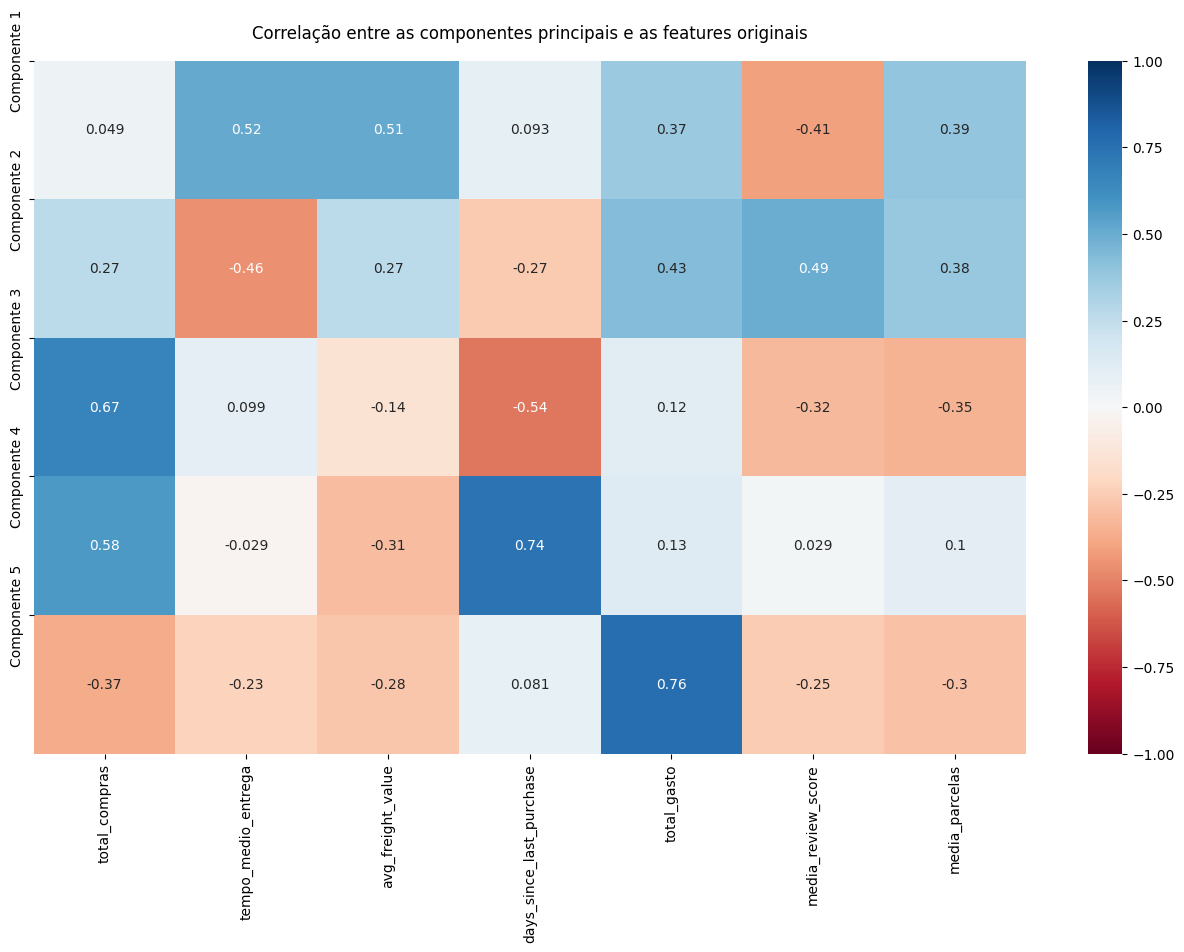

In [59]:
plt.figure(figsize=(16,9))
sns.heatmap(df_comp, annot=True, vmin=-1, vmax=1, cmap='RdBu')
plt.title("Correlação entre as componentes principais e as features originais", y=1.02)
plt.yticks([0,1,2,3, 4], ['Componente 1', 'Componente 2', 'Componente 3', 'Componente 4', 'Componente 5'])
plt.show()

#### Análise do mapa de calor
Para redução de dimensionalidade com PCA de 7 para 5 dimensões.

Componente 1: Tempo médio de entrega e valor médio do frete
- Eixo dos dados que aborda o tempo médio de entrega e o valor médio do frete, guardou com pouca essência o total gasto e a quantidade de parcelas.
- `tempo_medio_entrega`:      0.52 Correlação moderada positiva
- `avg_freight_value`:        0.51 Correlação moderada positiva
- `total_gasto`:              0.37 Correlação fraca positiva
- `media_parcelas`:           0.39 Correlação fraca positiva

Componente 2: Média de notas das reviews e dias desde a última compra
- Parte dos dados que aborda a média das notas de review, dias desde a última compra e a quantidade de parcelas na mesma proporção que PC1. `total_compras` não é bem representado por este eixo devido à baixa correlação.
- `media_review_score`:       0.49 Correlação moderada positiva
- `avg_freight_value`:        0.27 Correlação fraca positiva
- `days_since_last_purchase`: 0.43 Correlação moderada positiva
- `media_parcelas`:           0.38 Correlação fraca positiva
- `total_compras`:            0.27 Correlação fraca positiva

Componente 3: Total de compras feitas por cliente
- PC3 aborda a quantidade de compras feitas pelos clientes.
- `total_compras`:            0.67 Correlação forte positiva

Componente 4: Quantidade de compras e dias desde a última aquisição
- PC4 é a parte dos dados que aborda dias desde a última compra e a quantidade total de compras.
- `days_since_last_purchase`  0.74 Correlação forte positiva
- `total_compras`:            0.58 Correlação moderada positiva

Componente 5: Total Gasto por cliente
- PC5 é o eixo dos dados aborda a quantidade de dinheiro despendida pelos clientes.
- `total_gasto`:              0.76 Correlação forte positiva

Em um case real, nomearíamos cada feature componente principal de acordo com sua essência, neste caso a essência de cada um corresponde à alta correlação com as variáveis originais. Onde, por exemplo, o Componente 5 absorveu maior parte do valor despendido pelo cliente na empresa, poderia ser renomeado para total_gasto. Quanto maior a quantidade de features com correlação positiva, maior a dificuldade de nomear os componentes principais em razão da natureza do PCA capturar a essência do dataset de diferentes formas.

In [60]:
# Reduzindo de fato a dimensionalidade
df_pca = pca.transform(scaled_features)
df_pca = pd.DataFrame(df_pca)
df_pca.columns = ['Componente 1', 'Componente 2', 'Componente 3', 'Componente 4', 'Componente 5']

df_pca

,Componente 1,Componente 2,Componente 3,Componente 4,Componente 5
0,-0.173701,-0.431485,-0.847628,0.950447,0.290318
1,1.599631,1.364964,-1.122228,-0.424421,-1.093285
2,0.890024,0.345177,-0.215372,-0.577611,-1.005653
3,-0.418501,0.071927,0.149307,-0.555307,-0.090027
4,0.369221,1.481084,-0.277193,-0.902825,-0.750882
...,...,...,...,...,...
94715,-0.189993,0.619011,-0.180032,-0.312503,-0.205635
94716,-0.847441,0.544435,-0.034361,-0.386596,-0.043499
94717,2.054427,-1.740775,0.883034,-0.603563,-0.237871
94718,-0.025568,0.433860,-0.345981,0.250813,0.586264


### Calculando o Erro Quadrático para diversos números de clusters
Desta vez, com o PCA aplicado

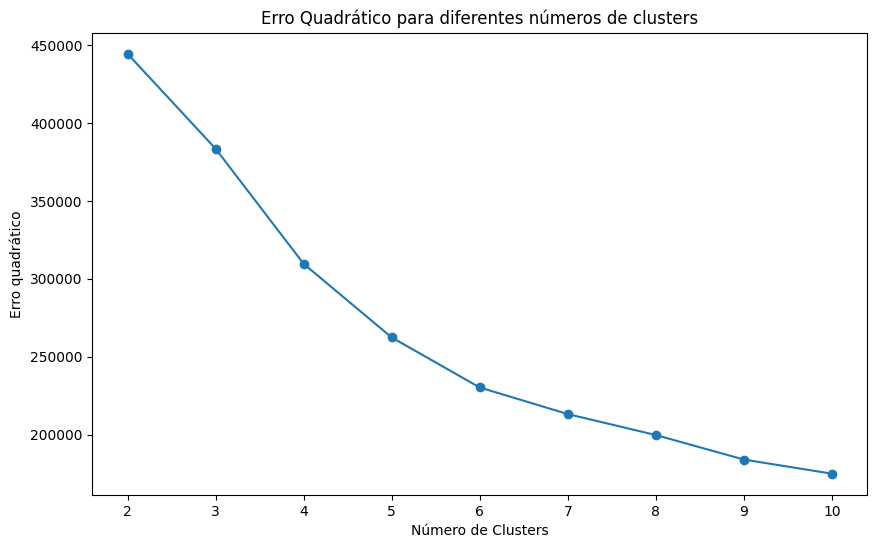

In [ ]:
# Métrica que calcula (a inércia) o Erro quadrático de cada cluster, quanto menor, mais denso o cluster
erro_quadratico = list()
for i in range(2,11):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(df_pca)
    erro_quadratico.append(km.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(2,11), erro_quadratico, marker='o')
plt.title("Erro Quadrático para diferentes números de clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Erro quadrático")
plt.show()

### Calculando o Índice de Silhouette no dataset redimensionado com PCA

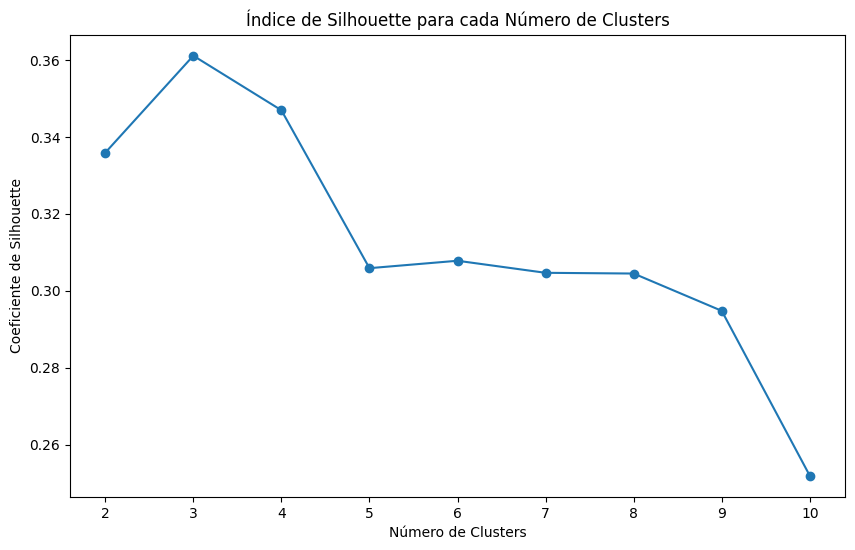

In [62]:
# Checando o Índice de Silhouette, identificando se o objeto está bem alocado no cluster.
silhouette = list()
for i in range(2,11):
    kmeans = KMeans(n_clusters=i, init='random')
    kmeans.fit(df_pca)
    silhouettescore = silhouette_score(df_pca, kmeans.labels_)
    silhouette.append(silhouettescore)
    
plt.figure(figsize=(10,6))
plt.plot(range(2,11), silhouette, marker='o')
plt.title("Índice de Silhouette para cada Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Coeficiente de Silhouette")
plt.show()

- O Erro Quadrático diminuiu em aproximadamente 100 mil unidades comparado com o anterior. Indicando uma
- O índice de Silhouette apresentou uma melhora de aproximadamente um décimo (0,1) com quatro clusters se comparado o anterior.

In [ ]:
# Agora, para dois componentes principais
pca2 = PCA(n_components=2)
pca2.fit(scaled_features)

PCA(n_components=2)

In [17]:
pca2.components_

array([[ 0.04887889,  0.51526721,  0.51264385,  0.09344082,  0.3735737 ,
        -0.40876813,  0.39233526],
       [ 0.27100359, -0.4565045 ,  0.26955238, -0.26522475,  0.43400236,
         0.49385563,  0.37802991]])

Pode-se confirmar que os autovalores e autovetores permanecem os mesmos.

Aplicando o método do cotovelo (inércia) e Índice de Silhouette para dois componentes principais para comparar o valor das métricas

In [ ]:
# Reduzindo de fato a dimensionalidade para dois componentes principais
df_pca2 = pca2.transform(scaled_features)
df_pca2 = pd.DataFrame(df_pca2)
df_pca2.columns = ['Componente 1', 'Componente 2']

df_pca2

,Componente 1,Componente 2
0,-0.173701,-0.431485
1,1.599631,1.364964
2,0.890024,0.345177
3,-0.418501,0.071927
4,0.369221,1.481084
...,...,...
94715,-0.189993,0.619011
94716,-0.847441,0.544435
94717,2.054427,-1.740775
94718,-0.025568,0.433860


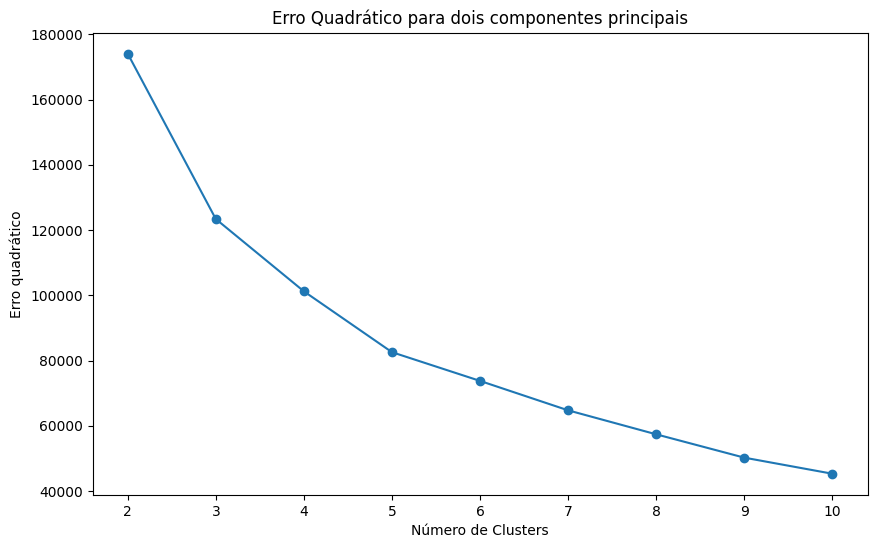

In [24]:
# Métrica que calcula (a inércia) o Erro quadrático de cada cluster, quanto menor, mais denso o cluster
erro_quadratico = list()
for i in range(2,11):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(df_pca2)
    erro_quadratico.append(km.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(2,11), erro_quadratico, marker='o')
plt.title("Erro Quadrático para dois componentes principais")
plt.xlabel("Número de Clusters")
plt.ylabel("Erro quadrático")
plt.show()

A inércia diminuiu (como esperado) de ~300.000 para 100.000 falando em 4 clusters.

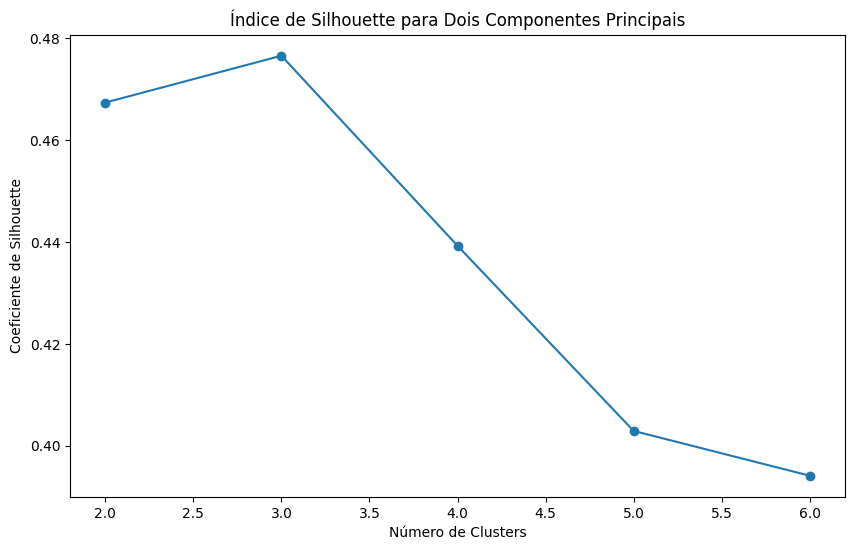

In [25]:
# Checando o Índice de Silhouette, identificando se o objeto está bem alocado no cluster para dois componentes principais.
silhouette = list()
for i in range(2,7):
    kmeans = KMeans(n_clusters=i, init='random')
    kmeans.fit(df_pca2)
    silhouettescore = silhouette_score(df_pca2, kmeans.labels_)
    silhouette.append(silhouettescore)
    
plt.figure(figsize=(10,6))
plt.plot(range(2,7), silhouette, marker='o')
plt.title("Índice de Silhouette para Dois Componentes Principais")
plt.xlabel("Número de Clusters")
plt.ylabel("Coeficiente de Silhouette")
plt.show()

O coeficiente de Silhouette aumentou de 0.34 para aproximadamente 0.44 (para 4 clusters) confirmando que, às vezes, menor variância também significa clusters mais bem definidos.

### Aplicando KMeans

In [41]:
kmeans_pca = KMeans(n_clusters=4, n_init=10, init='random', max_iter=300)
kmeans_pca.fit(df_pca2) # 2 componentes principais

KMeans(init='random', n_clusters=4, n_init=10)

In [42]:
df_pca2['Cluster'] = kmeans_pca.labels_
df_pca2.head()

,Componente 1,Componente 2,Cluster
0,-0.173701,-0.431485,2
1,1.599631,1.364964,3
2,0.890024,0.345177,3
3,-0.418501,0.071927,2
4,0.369221,1.481084,3


In [70]:
# concatenando o dataset original com as colunas dos componentes
# concat transforma inteiros em floats, caso haja uma coluna float no dataset original

df_result = pd.concat([df.drop(columns='customer_unique_id', axis=1), df_pca2], axis=1)
# transformando a coluna Cluster em inteiro novamente.
df_result['Cluster'] = df_result['Cluster'].fillna(0).astype(int) 
df_result.head()

,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score,media_parcelas,Componente 1,Componente 2,Cluster
0,1.0,8.0,21.88,474.0,146.87,4.0,2.0,-0.173701,-0.431485,2
1,1.0,16.0,46.48,233.0,335.48,5.0,8.0,1.599631,1.364964,3
2,1.0,26.0,17.79,106.0,157.73,5.0,7.0,0.890024,0.345177,3
3,1.0,14.0,23.36,173.0,173.30,5.0,1.0,-0.418501,0.071927,2
4,1.0,11.0,22.25,35.0,252.25,5.0,8.0,0.369221,1.481084,3


In [71]:
df_group_result = df_result.groupby('Cluster').mean()
df_group_result

,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score,media_parcelas,Componente 1,Componente 2
Cluster,,,,,,,,,
0,1.009947,11.947588,20.241334,243.313833,205.885757,4.100760,2.902845,4.028555,2.522558
1,1.042754,11.891860,20.126813,239.678106,209.822602,4.110031,2.891653,1.162555,-1.380673
2,1.038423,12.082930,20.271425,242.463266,215.899183,4.101984,2.914509,-0.707639,0.008313
3,1.041828,12.030118,20.139249,243.820640,217.168359,4.097612,2.869570,0.636024,1.005818


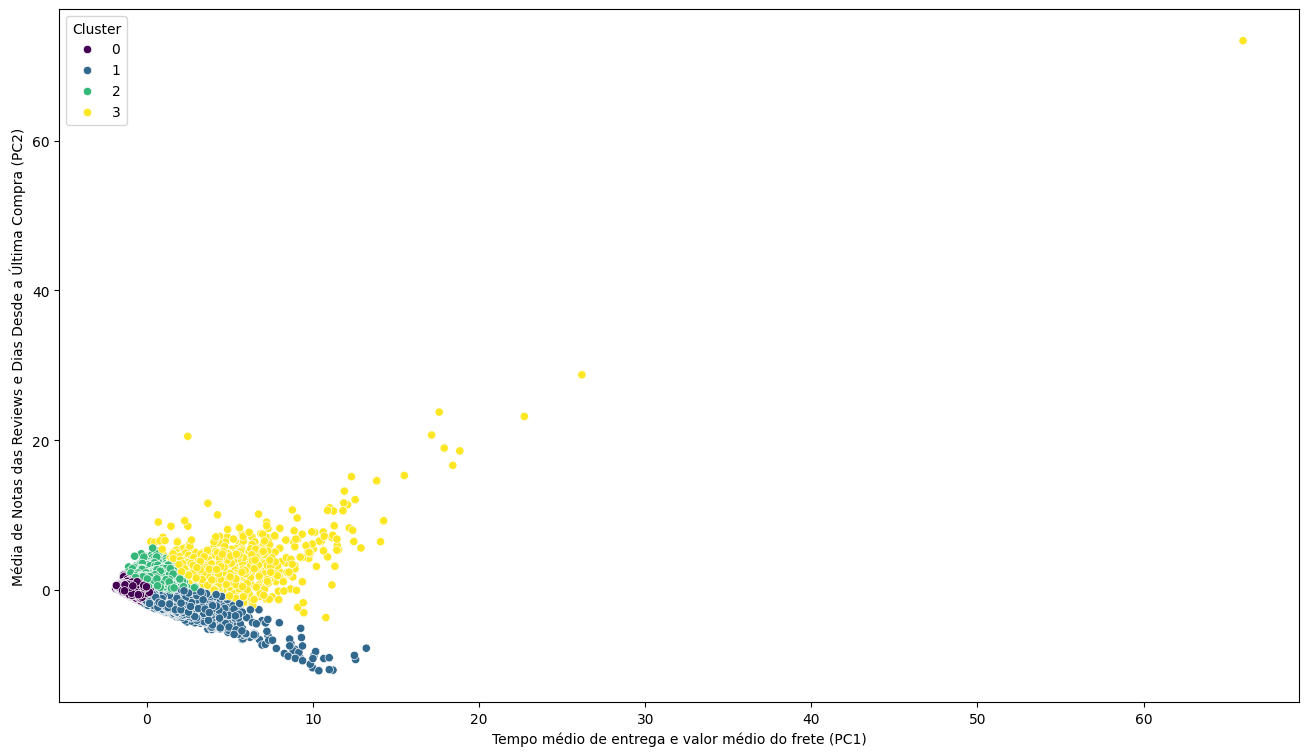

In [34]:
# Gráfico de pontos, comparando duas componentes. É possível visualizar que o PCA facilita a visualização entre clusters

plt.figure(figsize=(16,9))
sns.scatterplot(data=df_pca2, x='Componente 1', y='Componente 2', hue='Cluster', palette='viridis')
plt.xlabel('Tempo médio de entrega e valor médio do frete (PC1)')
plt.ylabel('Média de Notas das Reviews e Dias Desde a Última Compra (PC2)')
plt.show()

Perfil dos clientes identificado pelo KMeans (PCA). Antes de iniciar uma análise, devemos verificar como os outros algoritmos performam e quando encontrar o melhor, providenciar uma solução para o problema a ser resolvido.

# Aplicando Clusterização com DBSCAN

In [70]:
k = 8
neigh = NearestNeighbors(n_neighbors = k)
nbrs = neigh.fit(scaled_features)
distances, indices = nbrs.kneighbors(scaled_features)

distances = np.sort(distances, axis=0)
distances = distances[:, k-1]

In [71]:
distances

array([1.22865888e-02, 1.35818412e-02, 1.38988298e-02, ...,
       3.93029891e+01, 4.75969342e+01, 1.38057700e+02])

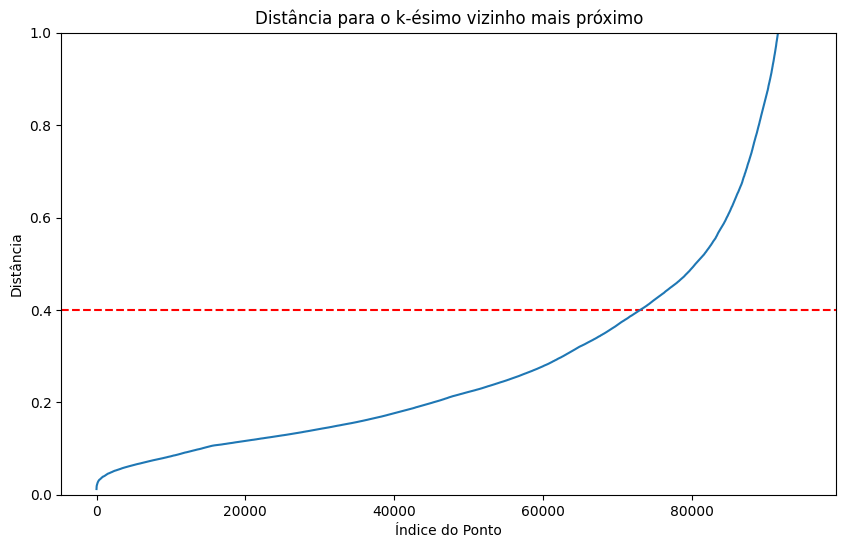

In [72]:
plt.figure(figsize=(10,6))
plt.axhline(y=0.4, color='r', linestyle='--')
plt.ylim(0,1)
plt.plot(distances)
plt.title("Distância para o k-ésimo vizinho mais próximo")
plt.xlabel("Índice do Ponto")
plt.ylabel("Distância")
plt.show()

0,4 É a região em que a distância não cresce significativamente. Antes do "cotovelo" as distâncias são maiores. Após o "cotovelo" são áreas com menor densidade e com maior distância, isso resultaria no uso de dados ruidosos e dados considerados como outliers.

In [73]:
# DBSCAN com dois componentes principais
df_DBSCAN = df_pca2.copy()
eps_val= 0.4
min_samples_val = 8

df_DBSCAN.drop(columns='Cluster', axis=1, inplace=True)
clustering = DBSCAN(eps=eps_val, min_samples=min_samples_val).fit(df_pca2)
df_DBSCAN['cluster'] = clustering.labels_

df_DBSCAN

,Componente 1,Componente 2,cluster
0,-0.173701,-0.431485,0
1,1.599631,1.364964,1
2,0.890024,0.345177,1
3,-0.418501,0.071927,0
4,0.369221,1.481084,1
...,...,...,...
94715,-0.189993,0.619011,0
94716,-0.847441,0.544435,0
94717,2.054427,-1.740775,2
94718,-0.025568,0.433860,0


In [74]:
df_DBSCAN.groupby('cluster').mean()

,Componente 1,Componente 2
cluster,,
-1,7.538702,2.945354
0,-0.707639,0.008313
1,0.636288,1.003334
2,1.136337,-1.360206
3,3.565399,2.125236


DBSCAN identificou 4 clusters, sendo o "-1" um aglomerado de outliers.

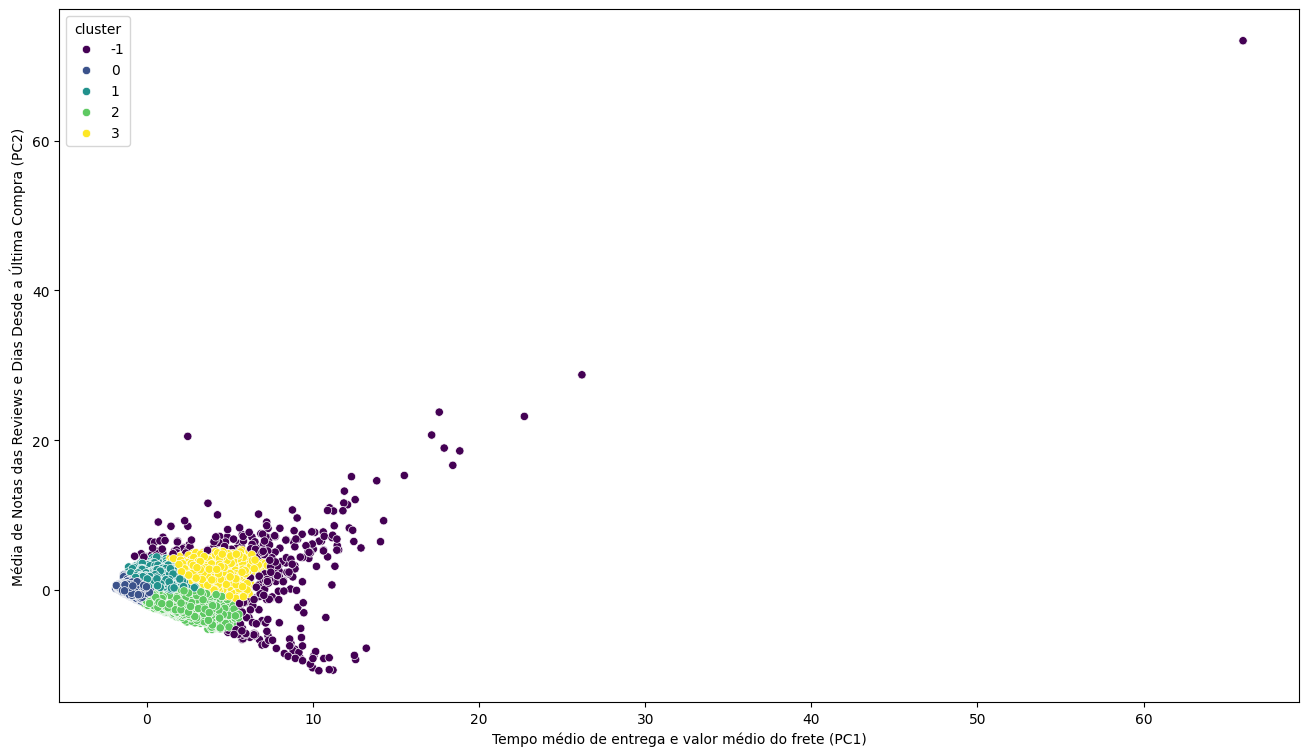

In [75]:
# Gráfico de pontos, comparando duas componentes. É possível visualizar que o PCA facilita a visualização entre clusters
plt.figure(figsize=(16,9))
sns.scatterplot(data=df_DBSCAN, x='Componente 1', y='Componente 2', hue='cluster', palette='viridis')
plt.xlabel('Tempo médio de entrega e valor médio do frete (PC1)')
plt.ylabel('Média de Notas das Reviews e Dias Desde a Última Compra (PC2)')
plt.show()

A identificação dos clusters está bem melhor que o KMeans (com PCA).

In [76]:
# verificando os outliers ("cluster -1" definido pelo DBSCAN)
df_DBSCAN[df_DBSCAN['cluster'] == -1]

,Componente 1,Componente 2,cluster
132,2.324657,5.394083,-1
359,5.731441,-6.608675,-1
430,6.139711,-3.691262,-1
604,0.420809,6.334483,-1
731,1.662372,5.211332,-1
...,...,...,...
93707,9.759760,5.033477,-1
93709,7.399514,3.980568,-1
93714,6.997487,5.165755,-1
93805,17.895983,18.958110,-1


DBSCAN classificou 302 instâncias como outliers.

### Comparando outliers com valores dentro dos limites do Boxplot

In [77]:
# outliers
df_DBSCAN_outliers=df_DBSCAN[df_DBSCAN['cluster'] == -1]

# dentro do limite do box plot
df_DBSCAN_sem_outliers=df_DBSCAN[df_DBSCAN['cluster'] != -1]

In [78]:
# resumo estatístico para os outliers
df_DBSCAN_outliers.describe()

,Componente 1,Componente 2,cluster
count,302.000000,302.000000,302.0
mean,7.538702,2.945354,-1.0
std,4.990276,7.672966,0.0
min,-0.739317,-10.778318,-1.0
25%,5.739969,-1.690349,-1.0
50%,7.236514,4.459847,-1.0
75%,9.209380,6.511072,-1.0
max,65.988528,73.351334,-1.0


In [79]:
# resumo estatístico para valores dentro dos limites do boxplot
df_DBSCAN_sem_outliers.describe()

,Componente 1,Componente 2,cluster
count,94418.000000,94418.000000,94418.000000
mean,-0.024113,-0.009421,0.620750
std,1.129927,0.994559,0.848775
min,-1.876238,-5.261518,0.000000
25%,-0.816963,-0.518763,0.000000
50%,-0.270545,0.021855,0.000000
75%,0.504373,0.522473,1.000000
max,7.244906,5.446358,3.000000


Neste momento, posso comparar o DBSCAN com KMeans (com e sem PCA) utilizando o Silhouette Score

In [82]:
# Índice de Silhouette, identificando se o objeto está bem alocado no cluster.
silhouette = list()

dbscan_ss = DBSCAN(eps=0.4, min_samples=8).fit(df_pca2)
silhouettescore = silhouette_score(df_pca2, clustering.labels_)

silhouette.append(silhouettescore)
    
print(silhouette)

[0.5327537512265761]


O __coeficiente de Silhouette__ para o **DBSCAN** foi **0.53**, melhor que o **KMeans (com PCA)** cujo coeficiente resultou em **0.44**, ambos para 4 clusters.

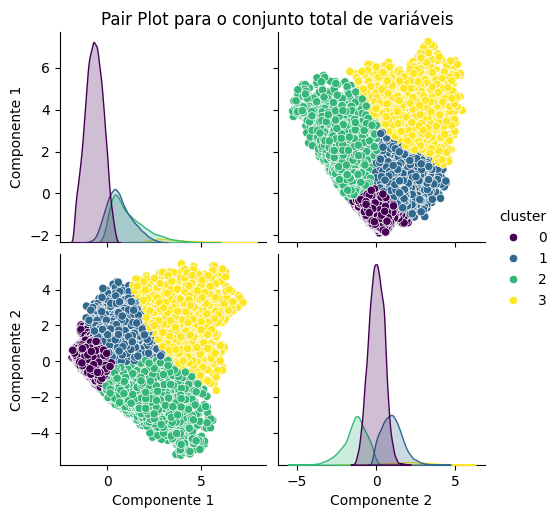

In [ ]:
# Gráfico pairplot (análise bivariada entre os 2 componentes principais)

sns.pairplot(df_DBSCAN_sem_outliers, hue='cluster', palette='viridis')
plt.suptitle("Pair Plot para o conjunto total de variáveis", y=1.02)
plt.show()

Os outliers podem apresentar informações interessantes em situações reais, mas neste estudo de caso prefiro ignorá-los.
O DBSCAN encontrou diferentes densidades de forma coesa.

In [ ]:
df_dbscan_radar = df.drop(columns='customer_unique_id', axis=1).copy()
df_dbscan_radar['cluster'] = clustering.labels_
df_dbscan_radar.head()

,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score,media_parcelas,cluster
0,1,8.0,21.88,474,146.87,4.0,2.0,0
1,1,16.0,46.48,233,335.48,5.0,8.0,1
2,1,26.0,17.79,106,157.73,5.0,7.0,1
3,1,14.0,23.36,173,173.30,5.0,1.0,0
4,1,11.0,22.25,35,252.25,5.0,8.0,1


In [ ]:
# normalizado e visualizando valores
valores_radar = df_dbscan_radar.groupby('cluster').mean(numeric_only=True)
valores_radar = cluster_avg.div(cluster_avg.max())
valores_radar.iloc[1:] # ignorando os outliers

,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score,media_parcelas
cluster,,,,,,,
0,0.622007,0.187669,0.160810,0.823085,0.028573,1.000000,0.232779
1,0.696647,0.236901,0.291298,0.762733,0.089906,0.973160,0.764337
2,0.620926,0.454049,0.221192,1.000000,0.044425,0.461795,0.342724
3,0.672080,0.342612,0.800431,0.794700,0.321620,0.795776,1.000000


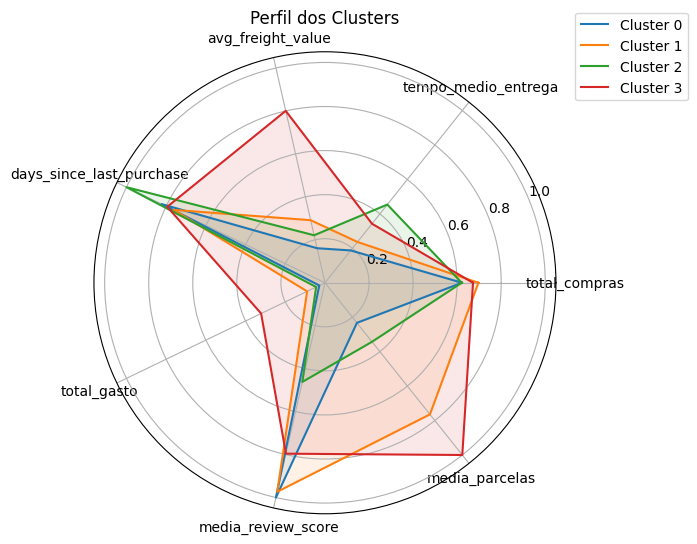

In [133]:
# Agrupando e Normalizando para a mesma escala, médias por cluster
cluster_avg = df_dbscan_radar.groupby('cluster').mean(numeric_only=True)
cluster_avg = cluster_avg.div(cluster_avg.max())  # normalização

# defino as labels sendo nome das colunas
labels = cluster_avg.columns
n_vars = len(labels)

# definindo o design como gráfico de
angles = np.linspace(0, 2 * np.pi, n_vars, endpoint=False).tolist()
angles += angles[:1]  # fecha o gráfico

# define o gráfico como subplots e itera sob as colunas e ângulos, adicionando-os
fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

for i, row in cluster_avg.iterrows():
    if i == -1: # não desejo visualizar os outliers identificados pelo DBSCAN
        continue
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Cluster {round(i)}')
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Perfil dos Clusters")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

### Perfil dos Clusters (DBSCAN) com base na métrica RFM:

| Cluster | Classificação RFM                  | Destaques                                                     | Ação recomendada                            |
| ------- | ---------------------------------- | ------------------------------------------------------------- | ------------------------------------------- |
| 0       | Fiéis de baixo ticket              | Avaliações excelentes, mas pouco valor monetário              | Campanhas personalizadas                    |
| 1       | Promissores / Leais                | Engajamento alto, avaliações excelentes, ticket intermediário | Fidelização, antecipação de ofertas         |
| 2       | Dormindo / Inativos                | Alta recência, baixo valor e review péssimo                   | Reativação, diagnóstico de abandono         |
| 3       | Clientes em rísco                  | Logística cara, gasto médio, avaliações medianas              | Descontos no frete e retenção estratégica   |

#### Cluster 0 – Fiéis de baixo ticket
- Baixo total_gasto
- Frequência moderada em total_compras
- Alta recência (days_since_last_purchase baixo)
- Alta satisfação (media_review_score alta)
- Baixo valor de parcelas e frete baixos

#### Cluster 1 – Promissores ou leais
- Gasto moderado
- Alta frequência (total_compras)
- Alta recência (clientes recentes)
- Alto score de avaliação
- Parcelamento alto

#### Cluster 2 – Clientes inativos
- Baixo total_gasto
- Frequência razoável
- Recência ruim (days_since_last_purchase alto)
- Score de review baixo
- Parcelamento baixo

#### Cluster 3 – Clientes em risco
- Gasto moderado
- Baixa frequência (total_compras)
- Alta recência (clientes antigos)
- Alta insatisfação (media_review_score mediano)
- Alto avg_freight_value e tempo_medio_entrega

# OPTICS - Aplicando o algoritmo com e sem PCA

In [ ]:
# OPTICS sem PCA
# define os parâmetros do modelo OPTICS
optics_model = OPTICS(eps=0.4, min_samples=8)

# determina um cluster para cada ponto
optics_result = optics_model.fit_predict(scaled_features)

In [ ]:
# OPTICS sem PCA
# acrescentando os rótulos
df_optics = pd.DataFrame()
df_optics = df.copy()
df_optics['cluster'] = optics_result

df_optics.head()

,customer_unique_id,total_compras,tempo_medio_entrega,avg_freight_value,days_since_last_purchase,total_gasto,media_review_score,media_parcelas,cluster
0,861eff4711a542e4b93843c6dd7febb0,1,8.0,21.88,474,146.87,4.0,2.0,-1
1,290c77bc529b7ac935b93aa66c333dc3,1,16.0,46.48,233,335.48,5.0,8.0,-1
2,060e732b5b29e8181a18229c7b0b2b5e,1,26.0,17.79,106,157.73,5.0,7.0,-1
3,259dac757896d24d7702b9acbbff3f3c,1,14.0,23.36,173,173.30,5.0,1.0,-1
4,345ecd01c38d18a9036ed96c73b8d066,1,11.0,22.25,35,252.25,5.0,8.0,-1


In [106]:
df_optics['cluster'].value_counts().sort_index()

cluster
-1       81065
 0           8
 1           9
 2          10
 3          14
         ...  
 1032        8
 1033        9
 1034       19
 1035       28
 1036        9
Name: count, Length: 1038, dtype: int64

Optics **sem** PCA identificou 81 mil instâncias como outliers e também identificou mil clusters.

Agora, o OPTICS **com** PCA:

In [109]:
# OPTICS com PCA
# acrescentando os rótulos visando verificar o índice de silhouette
df_optics_pca2 = pd.DataFrame()
df_optics_pca2 = df_pca2.copy()
df_optics_pca2.drop(columns='Cluster', axis=1, inplace=True)

df_optics_pca2.head()

,Componente 1,Componente 2
0,-0.173701,-0.431485
1,1.599631,1.364964
2,0.890024,0.345177
3,-0.418501,0.071927
4,0.369221,1.481084


In [111]:
# OPTICS sem PCA
# define os parâmetros do modelo OPTICS
optics_model = OPTICS(eps=0.4, min_samples=8)

# determina um cluster para cada ponto
optics_result = optics_model.fit_predict(df_optics_pca2)

In [112]:
df_optics_pca2['cluster'] = optics_result
df_optics_pca2.head()

,Componente 1,Componente 2,cluster
0,-0.173701,-0.431485,-1
1,1.599631,1.364964,2611
2,0.890024,0.345177,2302
3,-0.418501,0.071927,-1
4,0.369221,1.481084,-1


In [113]:
df_optics_pca2['cluster'].value_counts().sort_index()

cluster
-1       56699
 0          19
 1          20
 2          23
 3           8
         ...  
 2842       10
 2843        8
 2844       12
 2845        9
 2846       17
Name: count, Length: 2848, dtype: int64

OPTICS identificou 2846 clusters e 56.699 instâncias como outliers com o mesmo épsilon e min_samples que o DBSCAN. Distribuição dos dados não está interpretável em razão da quantidade de clusters.
- Sendo epsilon: Distância máxima entre dois pontos para que um seja considerado vizinho do outro.
- Sendo minPts: Quantos pontos vizinhos são necessários para um ponto ser considerado núcleo de um cluster.

Devido ao **péssimo** resultado de agrupamento do OPTICS (com e sem PCA), decido por **não** obter o coeficiente de Silhouette.

# Conclusão

O algoritmo que se saiu melhor foi o **DBSCAN** com PCA, de acordo com o Índice de Silhouette.

Próximos passos em um cenário real seriam:
- Concatenar a base de dados para ser possível identificar cada cliente por um ID;
- Separar os clientes em grupos: os que receberão as campanhas personalizadas e os que não receberão;
- Providenciar informações legíveis e interpretáveis para os times de marketing e vendas; e
- Após a implementação das estratégias de campanhas personalizadas pelos time supracitados, observar os resultados, comparar com períodos anteriores, comparar também com o grupo que não recebeu as campanhas e identificar pontos de melhoria visando maximizar o lucro.
- Uma opção ainda, seria dividir os clientes em mais grupos, utilizar os KMeans e DBSCAN para fazer diferentes campanhas e identificar qual algoritmo representou a realidade na prática, isto é, nos grupos que receberam e não receberam o marketing direcionado.